# Implement a custom Autoencoder with Koopman layer

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Preprocess Data
3) Make sure sim data is different for different ground parameters
4) Validation data has different batch size. Address when HP training
5) Address semi graident issue for K^m*z in linearity loss (Prob fine)

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

import  numpy as np
import pandas as pd

import matplotlib.colors as mcol
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.animation as animation

import seaborn as sns

import time 
import os

import glob
import csv


In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [3]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Data

### Read Sim Data Functions

In [5]:
def preprocessSimData(df, desiredStates:list, initialIndex:int=300, finalIndex:int=812):
    '''
    Preprocess text file (fixing formatting issue in data as well) while returning a dataframe object with the desired states selected

    Parameters:
    -----------
    df: dataFrame
        Panda dataframe that is read from one of the recorded simulation .txt files
    desiredStates: list
        List of desired states to return as a panda dataframe object in sequential order

    Return:
    ----------
    stateMatrix: dataFrame
        State matrix with desired states
    '''



    # Fix formatting Variables
    falseList = ['time_lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort', 'nan']
    df.columns = falseList
    df['time_lf_hip_joint_position'] = df.time_lf_hip_joint_position.str[0:8] + ' ' + df.time_lf_hip_joint_position.str[8:]


    # Data and State Name List
    data = df.values # np array of data values
    namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']

    dictStates = {}
    staticCounter = 0 # Variable to account for formatting issue
    for index in range(len(namesList)-1):
        if index == 0 and staticCounter == 0: # Condition for formatting issue of collected data
            for j in range(len(data[:,index])): # Looping through all elements in column 0 and converting to float
                if j == 0: # Initialize array
                    array1 = float(data[j,index][0:8])
                    #print(array1)
                    array2 = float(data[j,index][8:])
                    #print(array2)
                else:
                    array1 = np.vstack((array1,float(data[j,index][0:8])))
                    array2 = np.vstack((array2,float(data[j,index][8:])))
            dictStates[namesList[index]] = np.squeeze(array1[initialIndex:finalIndex])
            dictStates[namesList[index+1]] = np.squeeze(array2[initialIndex:finalIndex])        
        else:
            dictStates[namesList[index+1]] = data[initialIndex:finalIndex,index]
    for counter, names in enumerate(desiredStates):
        if counter == 0:
            stateMatrix = np.reshape(dictStates[names], (-1,1))
        else:
            stateMatrix = np.hstack((stateMatrix, np.reshape(dictStates[names], (-1,1))))
    return pd.DataFrame(stateMatrix, columns = desiredStates)



def preprocessFile(fileNames:list, initialIndex:int, finalIndex:int, desiredStates:list):
    '''
    Given fileNames to read, reads the file(s) and returns all data concatenated in a panda dataframe framework

    Paramaters:
    -----------
    fileNamess:list
        List of filenames to read and concatenate data together
    intialIndex: int
        Index to start reading each file's data from
    finalIndex: int
        Index to stop reading each file's data from
    desiredStates:list
        List of states to read
    
    Return:
    ----------
    totalData: dataFrame
        Returns data of all filenames with given states in one panda dataframe
    '''

    filePaths = []
    for i in fileNames:
        filePaths.append(glob.glob(i))
    #print(filePaths)


    dataFrameList = []
    for i in filePaths:
        for j in i:
            df = pd.read_csv(j, sep= " ", header=None)
            dataFrameList.append(preprocessSimData(df, desiredStates, initialIndex=initialIndex, finalIndex=finalIndex)) # 712-200 = 512 --> 512-1 is 512 indices (i.e. [0, 511])

    totalData = pd.concat(dataFrameList)
    return totalData

### Read full data

In [6]:
# List of states
namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']


In [7]:
desiredStates = ['lf_hip_joint_position', 'lf_hip_joint_vel', 'lf_hip_joint_effort']

input_dim = len(desiredStates)
output_dim = input_dim

trajLength = 2**6 # Length of each trajectory in the dataset

filePath = "simData"
fileNames = [filePath + '/empty_world_ground_2/joint_state_test_emptyWorld_forward_0.3*']


numTraj = 16 # Total number of trajectories in the dataset (train)
numTraj_val = 4
numTraj_test = 4
batch_size = int(2**8) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
numTraj_batch = int(batch_size/trajLength)

initialIndex, finalIndex= 200, 200+trajLength*(numTraj+numTraj_val+numTraj_test)

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)


In [8]:
doggoFrame = preprocessFile(fileNames,initialIndex,finalIndex, desiredStates)
doggoFrame.head(5)

,lf_hip_joint_position,lf_hip_joint_vel,lf_hip_joint_effort
0,0.0007,0.7994,1.5373
1,-0.0012,-1.2188,-0.5874
2,-0.001,0.5895,1.1941
3,-0.0023,-1.1606,-0.9001
4,-0.0003,1.0593,0.9021


Text(0.5, 1.0, 'Graph of data')

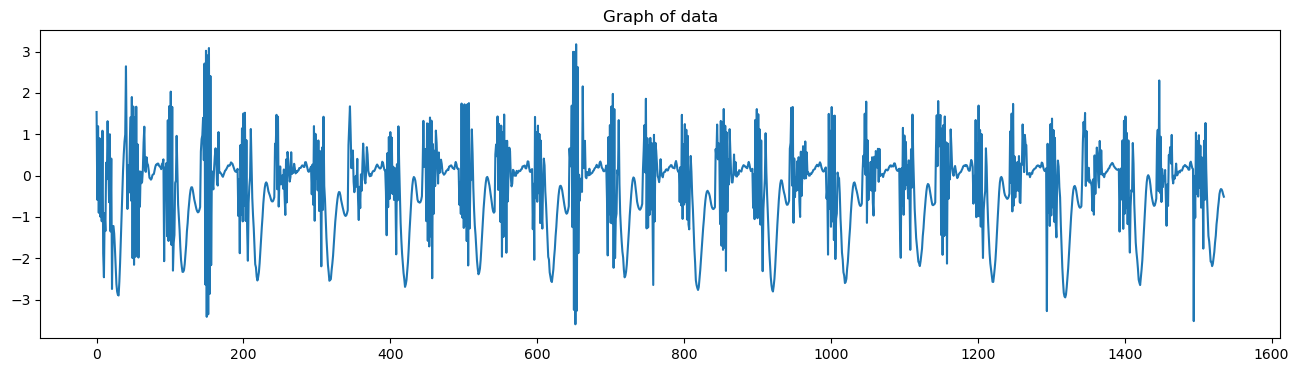

In [9]:
plt.figure(figsize=(16,4))
plt.plot(doggoFrame.values[0:2000,2])
plt.title("Graph of data")

Text(0.5, 1.0, 'Phase Portrait')

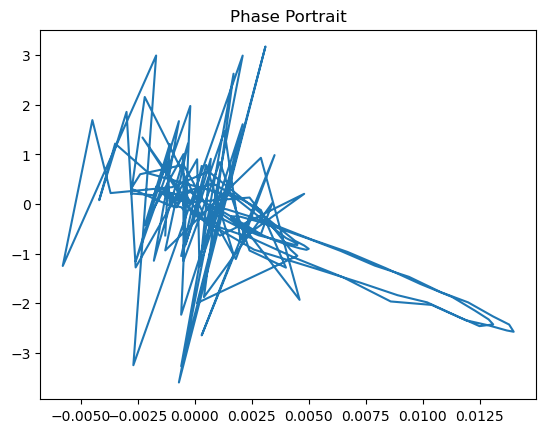

In [10]:
plt.plot(doggoFrame.values[600:800,0], doggoFrame.values[600:800,2])
plt.title("Phase Portrait")

In [11]:
print("Datapoints: ", len(doggoFrame.index))

Datapoints:  1536


In [12]:
doggo_train = doggoFrame.values[:numTraj*trajLength,:]
doggo_validation = doggoFrame.values[numTraj*trajLength:(numTraj+numTraj_val)*trajLength,:]
doggo_test = doggoFrame.values[(numTraj+numTraj_val)*trajLength:(numTraj+numTraj_val+numTraj_test)*trajLength,:]

doggo_train = np.asarray(doggo_train).astype('float32')
doggo_test = np.asarray(doggo_test).astype('float32')
doggo_validation = np.asarray(doggo_validation).astype('float32')

In [13]:
print("Size of doggo_train:", len(doggo_train))
print("Size of doggo_validation:", len(doggo_validation))
print("Size of doggo_test:", len(doggo_test))

Size of doggo_train: 1024
Size of doggo_validation: 256
Size of doggo_test: 256


### Make into dataset

In [14]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

doggo_train = (doggo_train - min_val) / (max_val - min_val)
doggo_validation = (doggo_validation - min_val) / (max_val - min_val)
doggo_test = (doggo_test - min_val) / (max_val - min_val)

train_data = tf.cast(doggo_train[0:batch_size*num_batches_train], tf.float32)
validation_data = tf.cast(doggo_validation[0:batch_size*num_batches_val], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(doggo_test, tf.float32)

In [15]:
x_train = train_data
y_train = train_data

# Custom Model definition

## Encoder

In [16]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a encoder layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [17]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None):
        super(EncoderModel, self).__init__(name=name)
        self.enc1 = EncoderLayer(16)
        self.enc2 = EncoderLayer(32)
        self.enc3 = EncoderLayer(64)
        self.enc4 = EncoderLayer(64)
        self.enc5 = EncoderLayer(16)
        self.enc6 = EncoderLayer(16)
        self.enc7 = EncoderLayer(16)

    def call(self, input):
        x = input
        x = self.enc1(x)
        x = tf.nn.tanh(x)
        x = self.enc2(x)
        x = tf.nn.elu(x)

        # Encoder output layer
        x = self.enc3(x)
        x = tf.nn.tanh(x)
        x = self.enc4(x)
        x = tf.nn.elu(x)
        x = self.enc5(x)
        x = tf.nn.tanh(x)
        x = self.enc6(x)
        x = tf.nn.elu(x)
        x = self.enc7(x)
        z = tf.nn.tanh(x)
        return z

## Koopman

In [18]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj_batch):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj_batch = numTraj_batch

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj_batch):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj_batch # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj_batch): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 #K = tf.zeros([latent_dim, latent_dim], dtype=tf.float32)
                 
                 indices = tf.constant([[traj*(self.trajLength-1)+m]])
                 if m == 0:
                    K = self.K 
                    # Matrix matvec works out to get Kz' and returns as row vector
                    updates = [tf.linalg.matvec(K, z1[traj,:])] #updates the row tensor at index = indices 
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    K = tf.matmul(K,self.K)
                    updates = [tf.linalg.matvec(K, z1[traj,:])]
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
           
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Z2,Z2_tilde)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))
        
        return Z, tf.matmul(Z1,self.K), Z2_tilde,

In [19]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    
    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    """
    
    def __init__(self, trajLength, numTraj_batch, name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj_batch)


    def call(self, input):
        z = input
        z, Z2_hat, z2_tilde = self.koopman(z)
        return z, Z2_hat, z2_tilde

## Decoder

In [20]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer

    W.T * input3 + b: tensor
        linear combination of weights times input3 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [21]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Prediction of the original state inputs x (label values are forward time shifted x)

    x2_tilde: tensor
        Prediction obtained by linearity from K 
    
    """
    
    def __init__(self, outputDim, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.dec1 = DecoderLayer(64)
        self.dec2 = DecoderLayer(64)
        self.dec3 = DecoderLayer(32)
        self.dec4 = DecoderLayer(64)
        self.outputLayer = DecoderLayer(outputDim)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        z, z2_hat, z2_tilde = self.dec1(z, z2_hat, z2_tilde)
        z = tf.nn.elu(z)
        z2_hat = tf.nn.elu(z2_hat)
        z2_tilde = tf.nn.elu(z2_tilde)

        z, z2_hat, z2_tilde = self.dec2(z, z2_hat, z2_tilde)
        z = tf.nn.elu(z)
        z2_hat = tf.nn.elu(z2_hat)
        z2_tilde = tf.nn.elu(z2_tilde)

        z, z2_hat, z2_tilde = self.dec3(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec4(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)
        #x_hat = tf.nn.elu(x_hat)
        #x2_hat = tf.nn.elu(x2_hat)
        #x2_tilde = tf.nn.elu(x2_tilde)

        return x_hat, x2_hat, x2_tilde

## Koopman Autoencoder

In [22]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, inputDim, outputDim, trajLength, numTraj, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel(outputDim)

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

# Custom Training Loop

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.batch(batch_size)

In [24]:
class MyStaticModel():
    def __init__(self, input_dim, batch_size, trajLength, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 

    ######################################  LOSS FUNCTIONS  ###################################################
    def tot_loss(self, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        #alpha1 = 0.1, alpha2 = 1e-7, alpha3 = 1e-15
        alpha1 = 0.1
        alpha2 = 1e-7
        alpha3 = 1e-15

        x2 = []
        x2_SP = []
        x2_tilde_SP = []
        for i in range(self.numtraj_batch):
            predict_length = self.trajLength-1
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength]) # forward time shift x to get x2
            x2_SP.append(x[i*self.trajLength+1:i*self.trajLength+predict_length+1]) # forward time shift x to get x2 for Sp timesteps
            #x2_tilde_SP.append(x2_tilde[i*self.trajLength+1:i*self.trajLength+predict_length+1]) # get Sp timesteps from x2_tilde
            # Shape currently goes from 31 to 27.. but somehow indexing does not work
            x2_tilde_SP = x2_tilde

        #print("In loss function x2", tf.shape(x2))
        #print("In loss function x2_SP", tf.shape(x2_SP))
        #print("In loss function x2_tilde_SP", tf.shape(x2_tilde_SP))

        x2 = tf.reshape(x2, [-1, x.shape[-1]])
        x2_SP = tf.reshape(x2_SP, [-1, x.shape[-1]])
        x2_tilde_SP = tf.reshape(x2_tilde_SP, [-1, x.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2_SP,x2_tilde_SP)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf), tf.norm(tf.subtract(x2,x2_hat), ord=np.inf))
        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + sum(model.losses)

    ###############################################  GRAPH FUNCTIONS     #########################################################

    def graphPlot(self, error, error_min, error_max, error_val, error_min_val, error_max_val):
        '''
        Graph plots for loss over all epochs
        Parameters:
        error: list
            Training Loss Error for all epochs
        error_val: list
            Validation Loss Error for all epochs
        '''
        saveFiles = True
        imgPath = 'graphs/'
        csvPath = 'csvFiles/'

        csvFileName = 'epochLosses.csv'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making graph folder. Folder already exists...")

            try:
                os.mkdir(csvPath)
            except:
                print("Tried making csv folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Training Loss")
        plt.plot(error_val, label = "Validation Loss")
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 
        plt.close()

        # Save data into csv file
        csvDict = {'Epoch Training Loss': error, 'Epoch Training Min Loss': error_min, 'Epoch Training Max Loss': error_max,
                    'Epoch Validation Loss': error_val, 'Epoch Validation Min Loss' : error_min_val, 
                    'Epoch Validation Max Loss': error_max_val}
        df = pd.DataFrame(csvDict)
        df.to_csv(csvPath+csvFileName)
            

    
    def graphBatchLossPlot(self, epochNum, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Batch Training Loss")
        plt.plot(error_val, label="Batch Validation Loss")
        textTitle = "BatchLoss_Epoch_%d" % (epochNum)
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
        plt.close() 

    
    def graphEigenfunctions(self, model, K):
        saveFiles = True
        imgPath = 'graphs/eigenfunctions/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        x1 = tf.linspace(-1,1,256)
        x2 = tf.linspace(-1,1,256)
        x1, x2 = tf.meshgrid(x1, x2)
        X = tf.reshape([[x1],[x2]], [-1, 2])

        Z = model.enc(X)
        complex_Z = tf.complex(Z, tf.zeros(tf.shape(Z))) # make Z complex with zero complex part

        eig_values, right_eig_vectors = tf.linalg.eig(tf.squeeze(K))
        W = tf.transpose(tf.linalg.inv(right_eig_vectors))
        Psi = tf.matmul(complex_Z,W)

        eig_dominant = tf.abs(eig_values)
        counter = 0
        for eig in eig_values:
            cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
            #normalize = mpl.colors.Normalize(vmin=np.min(Psi[:,counter]), vmax=np.max(Psi[:,counter]))
            plt.figure(counter)
            fig, axs = plt.subplots(2)
            
            p1 = axs[0].scatter(x1, x2, c=tf.abs(Psi[:,counter]).numpy(), cmap=cm1)
            fig.colorbar(p1, ax=axs[0])
            fig_title1 = "|Psi| %0.04f + %0.04f i"%(tf.math.real(eig),tf.math.imag(eig)) 
            axs[0].set_title(fig_title1)
            
            p2 = axs[1].scatter(x1, x2, c=tf.math.angle(Psi[:,counter]).numpy(), cmap=cm1)
            fig.colorbar(p2, ax=axs[1])
            fig_title2 = "angle(Psi) %0.04f + %0.04f i"%(tf.math.real(eig),tf.math.imag(eig))  
            axs[1].set_title(fig_title2)

            fig.tight_layout()
            textTitle = "Psi_%0.04f_epoch%d"%(eig, counter)
            counter += 1
            if saveFiles:
                plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
            plt.close('all') 

    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(5e-5)

        epochs = 10000     
        
        # Initialize variables for csv file
        epoch_train_loss = [] # total loss for each epoch
        epoch_train_min_loss = []
        epoch_train_max_loss = []
        
        epoch_validation_loss = []
        epoch_validation_min_loss = []
        epoch_validation_max_loss = []



        start_time_total = time.time()
        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []


            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                with tf.GradientTape() as tape:
                    reconstruction, prediction, linearity = model(x_batch_train)

                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, prediction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            min_train_loss = np.amin(batch_train_loss_list)
            max_train_loss = np.amax(batch_train_loss_list)
            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(min_train_loss)
            epoch_train_max_loss.append(max_train_loss)


            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, pred_val, linearity_val = model(x_batch_val)

                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, pred_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list))
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list))

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))
            #self.graphBatchLossPlot(epoch, batch_train_loss_list, batch_validation_loss_list)
            #K = model.koopman.get_weights()
            #self.graphEigenfunctions(model, K)

        self.graphPlot(epoch_train_loss, epoch_train_min_loss, epoch_train_max_loss, epoch_validation_loss, 
                        epoch_validation_min_loss, epoch_validation_max_loss)
        print("Total time taken: %.2fs" % (time.time() - start_time_total))

In [25]:
Training_class = MyStaticModel(input_dim, batch_size, trajLength, num_batches_train, num_batches_val)
koopmanAEModel = Koopman_AE_Model(input_dim, output_dim, trajLength, numTraj_batch, name="Koopman_AE_Model")
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.0681709
Epoch val loss: 0.06521233171224594
Time taken: 2.64s

Start of epoch 1
Average training loss at epoch 1: 0.0637404
Epoch val loss: 0.06107091158628464
Time taken: 4.32s

Start of epoch 2
Average training loss at epoch 2: 0.0597924
Epoch val loss: 0.05742296203970909
Time taken: 5.98s

Start of epoch 3
Average training loss at epoch 3: 0.0563048
Epoch val loss: 0.05419410765171051
Time taken: 7.61s

Start of epoch 4
Average training loss at epoch 4: 0.0532227
Epoch val loss: 0.05134476348757744
Time taken: 9.19s

Start of epoch 5
Average training loss at epoch 5: 0.0504964
Epoch val loss: 0.048805121332407
Time taken: 10.78s

Start of epoch 6
Average training loss at epoch 6: 0.0480679
Epoch val loss: 0.04654381796717644
Time taken: 12.43s

Start of epoch 7
Average training loss at epoch 7: 0.0458941
Epoch val loss: 0.04449497535824776
Time taken: 14.07s

Start of epoch 8
Average training loss at epoch 8: 0.0439255
Epoch val

# Plots on Train data

### Reconstruction

In [26]:
#input = x_train[batch_size*10:batch_size*11]
input = x_train
out1, out2, out3 = koopmanAEModel(input)

In [27]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

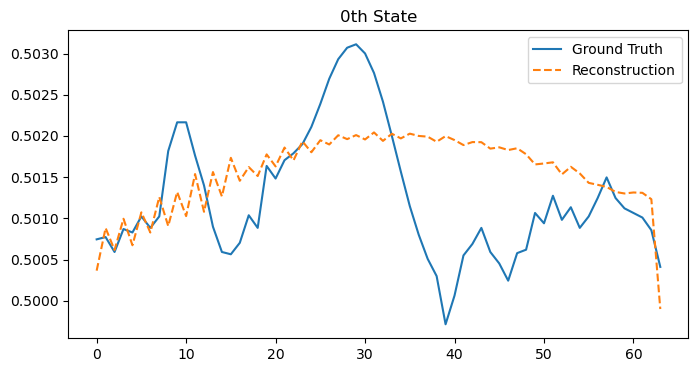

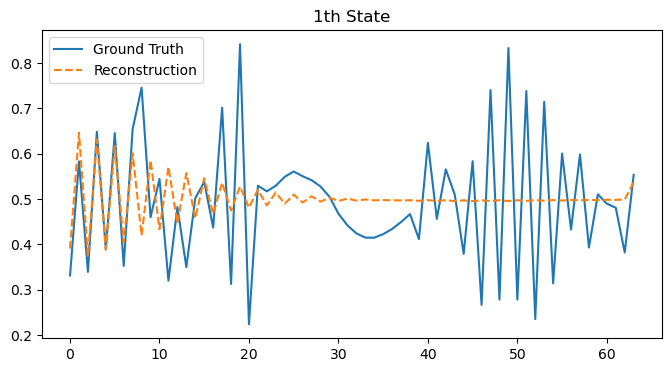

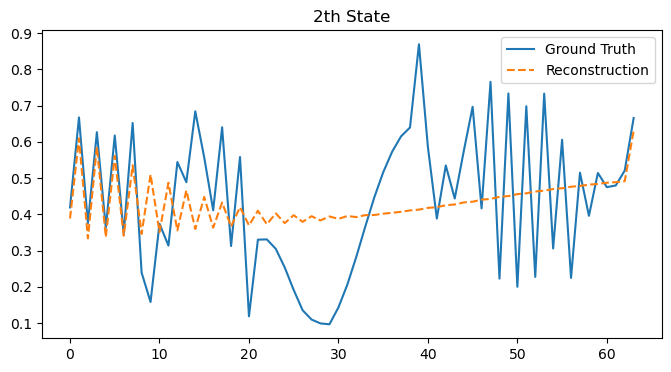

In [67]:
plt.rcParams['figure.figsize'] = [8, 4]
row,col = np.shape(input)

for i in range(col):
    plt.figure(i)
    plt.title("Batch Reconstruction")
    plt.plot(x2[0:trajLength,i], label = "Ground Truth")
    plt.plot(out3[0:trajLength,i], '--', label="Reconstruction")
    plt.title("%dth State" % i)
    plt.legend()

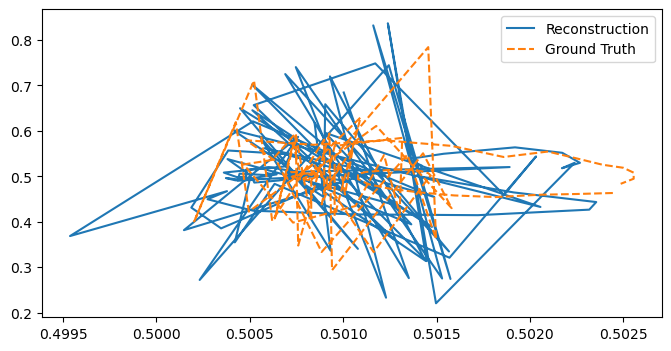

In [68]:
plt.plot(out1[0:100,0], out1[0:100,1], label="Reconstruction")
plt.plot(input[0:100,0], input[0:100,1], '--', label="Ground Truth")
plt.legend()

### Linear Prediction

### Graphing Error Section

#### Average Error Function

In [30]:
def preProcessForAvg(input, numTraj_batch, trajLength, num_batches, desiredStates, model):
    '''
    Given input, the number of trajectory in each batch, and the trajector length, outputs
    batch data concatenated vertically on top of one another by calling the Koopman AE class

    Parameters:
    -----------
    input: Tensor
        Input data to reshape into outputs
    numTraj_batch: int
        Number of trajectory per batch
    trajLength: int
        Number of snapshots in a trajectory
    desiredStates: list
        List of states
    model: Koopman AE keras model
        Koopman AE model to propagate data

    Return:
    ----------
    x1_all: tensor
        Copy of input (No need for change) (Ground Truth)
    x2_all: tensor
        Concatenated tensor of 1 time shifted data for all batches (Ground Truth)
    x3_all: tensor
        Concatenated tensor of 1 time step shifted data for all batches (x2_all=x3_all) (Ground Truth)
    out1_all: tensor
        Reconstruction of input (parameter) using the Koopman AE class
    out2_all: tensor
        Predicted output from Koopman model of concatenated tensors of 1 time shifted data for all batches
    out3_all: tensor
        Predicted n time step output from Koopman model of concatenated tensors data for all batches
    '''
    
    x2_all = []
    out1_all = []
    out2_all = []
    out3_all = []
    x = input


    # Loop through num of batches
    for i in range(num_batches):
        x2 = []
        # Within each batch, loop through trajectory number
        for j in range(numTraj_batch):
            x2.append(x[(i*numTraj_batch+j)*trajLength+1:(i*numTraj_batch+j+1)*trajLength])
        x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input for a batch
        x2_all.append(x2)
        
        x_input = x[i*numTraj_batch*trajLength:(i+1)*numTraj_batch*trajLength]
        out1, out2, out3 = model(x_input)
        out1_all.append(out1)
        out2_all.append(out2)
        out3_all.append(out3)
        
    x1_all = x
    x2_all = tf.reshape(x2_all,(-1,len(desiredStates)))
    x3_all = x2_all
    out1_all = tf.reshape(out1_all,(-1,len(desiredStates)))
    out2_all = tf.reshape(out2_all,(-1,len(desiredStates)))
    out3_all = tf.reshape(out3_all,(-1,len(desiredStates)))


    '''
    print(tf.shape(x2_all))
    print(tf.shape(out1_all))
    print(tf.shape(out2_all))
    print(tf.shape(out3_all))
    '''

    return x1_all, x2_all, x3_all, out1_all, out2_all, out3_all

In [31]:
def avgTrajError(gTruth, predicted, trajLength, numTraj):
    '''
    Get the average trajectory error

    Parameters:
    -----------
    gTruth: tensor or ndarray
        Ground Truth matrix
    predicted: tensor or ndarray
        Predicted matrix
    trajLength: int
        Length of trajectory
    numTraj: int
        Number of trajectory (total?)
    

    Return:
    ----------
    avgErrorList: list
        List of average errors of all trajectories (each index is the avg error of the states at a point of time along the trajectory)
    
    errorList: list
        List of error of all states and trajectory
    '''
    errorList = []
    avgErrorList = []
    numStates = len(gTruth[0,:])
    for i in range(numTraj):
        '''
        print("Gtruth")
        print(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:])
        print("Predicted")
        print(np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
        print("---Loop---")
        '''
        errorList.append(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:] - np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
    
    #print("Error List")
    #print(np.shape(errorList[0]))
    
    for j in range(trajLength):
        #print("Length of Traj %d"% j)
        for k in range(numTraj):
            #print("Traj: %d"% k)
            if k == 0:
                avgErrorList.append(errorList[k][j,:])
            else:
                #print(avgErrorList[j])
                avgErrorList[j] = (k*avgErrorList[j]+errorList[k][j,:])/(k+1) # Recursive average formula
    return avgErrorList, errorList
        
    

#### Preprocess Error Graph Data

In [32]:
saveErrorPath = 'errorGraph/'
try:
    os.mkdir(saveErrorPath)
except OSError as exc:
    print(exc.errno)

17


In [33]:
x1_all,x2_all,x3_all, out1_all,out2_all,out3_all = preProcessForAvg(x_train,numTraj_batch, trajLength, num_batches_train, desiredStates, koopmanAEModel)
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)

In [34]:
print(x2_all.shape)

(1008, 3)


#### Error Graphs

##### Reconstruction Error

In [35]:
avgTrajErrorList, errorList = avgTrajError(x1_all, out1_all, trajLength, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [36]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i],
                    avgTrajErrorArray[:,i]+errorStdDevArray[:,i], facecolor='lightsteelblue')
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'recon_error_'+title+'.png', dpi=300)
    plt.close()

##### Forward Time Shift Prediction Error

In [37]:
avgTrajErrorList, errorList = avgTrajError(x2_all, out2_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [38]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], 
                    avgTrajErrorArray[:,i]+errorStdDevArray[:,i],facecolor='lightsteelblue')
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Forward Time Shift Prediction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'ftimeShift_error_'+title+'.png', dpi=300)
    plt.close()

##### Linearity Prediction Error

In [39]:
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [40]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], 
                    avgTrajErrorArray[:,i]+errorStdDevArray[:,i],facecolor='lightsteelblue')
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Linear Prediction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'linPred_error_'+title+'.png', dpi=300)
    plt.close()

### Reconstruction/Forward Time Shift Prediction/Linear Prediction Graph

In [41]:
saveOutputPath = 'outputGraph/'
try:
    os.mkdir(saveOutputPath)
except OSError as exc:
    print(exc.errno)

17


In [42]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(x1_all[:,i])
    plt.plot(out1_all[:,i],'--',label="")
    plt.ylabel("Reconstruction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.savefig(saveOutputPath+'recon_'+title+'.png', dpi=300)
    plt.close()

In [43]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(x2_all[:,i])
    plt.plot(out2_all[:,i],'--',label="")
    plt.ylabel("Forward Time Shift Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.savefig(saveOutputPath+'ftimeShiftPred_'+title+'.png', dpi=300)
    plt.close()

In [44]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(x3_all[:,i])
    plt.plot(out3_all[:,i],'--',label="")
    plt.ylabel("Linear Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.savefig(saveOutputPath+'linPred_'+title+'.png', dpi=300)
    plt.close()

In [45]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

# Animate Graphs

## Animate Setup

In [46]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

In [47]:
mp4FilePath = 'mp4/'
try:
    os.mkdir(mp4FilePath)
except OSError as exc:
    print(exc.errno)

17


In [48]:
def animateStatesError(middleLine, boundLine, desiredStates:list, titlePrefix, mp4FilePath = 'mp4/', ifBoundLine=True, xlim=[0,128], ylim=[0,1]):
    '''
    Given the average trajectory error, standard deviation error, and desired states,
    animate the trajectory with given legend into a mp4 under the mp4 folder

    Parameters:
    -----------
    middleLine: ndarray
        Trajectory of the middle line (nxlen(desiredStates))
    boundLine: ndarray
        Trajectory of the bound for upper and lower bound (+/- stdDev)
    desiredStates: list
        List of the desired states
    titlePrefix: str
        Prefix title to save into mp4FilePath
    mp4FilePath: str
        Directory path to save mp4
    ifBoundLine: Boolean
        ifBoundLine is true, graphs with bounded fill between lines, else just graphs middle line
    xlim: list
        Limit of plot axis in x direction
    ylim: list
        Limit of axis in y direction


    Return:
    ---------
    None
    '''
    for j in range(np.shape(middleLine)[1]):
        # Set up figure, axis, and plot element want to animate
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        line, = ax.plot([],[], lw=1, label=desiredStates[j].replace("_", " "))
        plt.style.use('default')
        plt.legend()
        plt.tight_layout()

        # Initialize function: plot the background of each frame
        def init():
            line.set_data([], [])

            return line,


        # animation function called sequentially
        def animate(i, j):
            x = range(len(middleLine[0:i,j]))
            data = middleLine[0:i,j] #select data range
            line.set_data(x,data)
            line.set_color('#1f77b4')
        
            if ifBoundLine:
                p = plt.fill_between(range(len(boundLine[0:i,j])), middleLine[0:i,j]-boundLine[0:i,j], 
                                middleLine[0:i,j]+boundLine[0:i,j], facecolor='lightsteelblue')
                return line, p,
            else:
                return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=128,
                                    interval=10, repeat=True, blit=True, fargs=(j,))

        anim.save(mp4FilePath+titlePrefix+'_'+ desiredStates[j]+'.mp4', writer=writer, dpi=300)
        plt.close()

In [49]:
def animateStates(predictedLine, gTruthLine, label1, label2, desiredStates:list, titlePrefix, mp4FilePath = 'mp4/', ifGTruthLine=True, xlim=[0,128], ylim=[0,1]):
    '''
    Given the predicted and ground truth trajectory, as well as desired states,
    animate the trajectory with given legend into a mp4 under the mp4FilePath folder

    Parameters:
    -----------
    predictedLine: ndarray
        Trajectory of the predicted line (nxlen(desiredStates))
    gTruthLine: ndarray
        Trajectory of the ground truth line (+/- stdDev)
    label1: str
        Label for predicted line (suffix)
    label2: str
        Label for ground truth line (suffix)
    desiredStates: list
        List of the desired states
    titlePrefix: str
        Prefix title to save into mp4FilePath
    mp4FilePath: str
        Directory path to save mp4
    ifBoundLine: Boolean
        ifBoundLine is true, graphs with bounded fill between lines, else just graphs middle line
    xlim: list
        Limit of plot axis in x direction
    ylim: list
        Limit of axis in y direction
        
    Return:
    ---------
    None
    '''
    for j in range(np.shape(predictedLine)[1]):
        # Set up figure, axis, and plot element want to animate
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        line, = ax.plot([],[], lw=1, label=desiredStates[j].replace("_", " ") + " " + label1)
        line.set_color('#1f77b4')
        if ifGTruthLine:
            line2, = ax.plot([],[], lw=1, label=desiredStates[j].replace("_", " ") + " " + label2)
            line2.set_color('black')
            plt.setp(line2, linestyle='--')
        
        plt.style.use('default')
        plt.legend()
        plt.tight_layout()

        # Initialize function: plot the background of each frame
        def init():
            line.set_data([], [])
            if ifGTruthLine:
                line2.set_data([],[])
            return line,


        # animation function called sequentially
        def animate(i, j):
            x = range(len(predictedLine[0:i,j]))
            data = predictedLine[0:i,j] #select data range
            line.set_data(x,data)
            if ifGTruthLine:
                line2.set_data(x, gTruthLine[0:i,j])
          
            return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=128,
                                    interval=10, repeat=True, blit=True, fargs=(j,))

        anim.save(mp4FilePath+titlePrefix+'_'+ desiredStates[j]+'.mp4', writer=writer, dpi=300)
        plt.close()

## Animation Graphs

Trajectory

In [50]:
animateStates(x1_all, x1_all, 'State Trajectory', 'State Trajectory', desiredStates, 'trajectory', ifGTruthLine=False)

Error

In [51]:
# Reconstruction Error
avgTrajErrorList, errorList = avgTrajError(x1_all, out1_all, trajLength, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'train_recon_error')

# Forward Time Shift Prediction Error
avgTrajErrorList, errorList = avgTrajError(x2_all, out2_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'train_fTimeShiftPred_error')

# Linear Prediction Error
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'train_linPred_error')

Trajectory

In [52]:
animateStates(out1_all,x1_all,'Reconstruction','Truth',  desiredStates, 'train_traj_recon')
animateStates(out2_all,x2_all,'Forward Time Shift','Truth', desiredStates, 'train_traj_FTimeShiftPred')
animateStates(out3_all,x3_all,'Lin Pred','Truth', desiredStates, 'train_traj_linPred')

# Save the Model

In [53]:
koopmanAEModel.save('checkpoints/champ_Trained_Model')

INFO:tensorflow:Assets written to: checkpoints/champ_Trained_Model\assets


# Load the Model

In [54]:
new_model = tf.keras.models.load_model('checkpoints/champ_Trained_Model', compile=False)
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  8464      
_________________________________________________________________
koopman__model (Koopman_Mode multiple                  256       
_________________________________________________________________
decoder_model (DecoderModel) multiple                  9635      
Total params: 18,355
Trainable params: 18,355
Non-trainable params: 0
_________________________________________________________________


In [55]:
input = x_train
new_out1, new_out2, new_out3 = new_model(input)

# Plots on Test Data

## Test Graphs

In [56]:
saveTestOutputPath = 'testOutputGraph/'
try:
    os.mkdir(saveTestOutputPath)
except OSError as exc:
    print(exc.errno)

17


In [57]:
input = doggo_validation
new_out1, new_out2, new_out3 = new_model(input)

In [58]:
nx1_all,nx2_all,nx3_all,nout1_all,nout2_all,nout3_all = preProcessForAvg(input,numTraj_batch,trajLength,num_batches_val,desiredStates, new_model)

In [59]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx1_all[:,i], label="Ground Truth")
    plt.plot(nout1_all[:,i],'--',label="Predicted")
    plt.ylabel("Reconstruction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.legend()
    plt.savefig(saveTestOutputPath+'test_recon_'+title+'.png', dpi=300)
    plt.close()

In [60]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx2_all[:,i], label="Ground Truth")
    plt.plot(nout2_all[:,i],'--',label="Predicted")
    plt.ylabel("Forward Time Shift Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.legend()
    plt.savefig(saveTestOutputPath+'test_fTimeShift_'+title+'.png', dpi=300)
    plt.close()

In [61]:
for i in range(len(desiredStates)):
    plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx3_all[:,i], label="Ground Truth")
    plt.plot(nout3_all[:,i],'--',label="Predicted")
    plt.ylabel("Linear Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.ylim((0,1))
    plt.legend()
    plt.savefig(saveTestOutputPath+'test_linPred_'+title+'.png', dpi=300)
    plt.close()

In [62]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [63]:
mp4FilePath = 'mp4/'
try:
    os.mkdir(mp4FilePath)
except OSError as exc:
    print(exc.errno)

17


## Animation on Test

In [64]:
avgTrajErrorList, errorList = avgTrajError(nx1_all, nout1_all, trajLength, numTraj_val)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_recon_error', mp4FilePath, ifBoundLine=False)

avgTrajErrorList, errorList = avgTrajError(nx2_all, nout2_all, trajLength-1, numTraj_val)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_fTimeShiftPred_error', mp4FilePath, ifBoundLine=False)

avgTrajErrorList, errorList = avgTrajError(nx3_all, nout3_all, trajLength-1, numTraj_val)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_linPred_error', mp4FilePath, ifBoundLine=False)

Trajectory

In [65]:
animateStates(nout1_all,nx1_all,'Reconstruction','Truth',  desiredStates, 'test_traj_recon')
animateStates(nout2_all,nx2_all,'Forward Time Shift','Truth', desiredStates, 'test_traj_FTimeShiftPred')
animateStates(nout3_all,nx3_all,'Lin Pred','Truth', desiredStates, 'test_traj_linPred')